# Модель машиннго обученияь - H2O AutoML!!!

In [1]:
# импортируем библиотеки
import pandas as pd # работа с данными / python data analysis library
import numpy as np # работа с числовыми данными / python numerical computing library
import seaborn as sns # визуализация данных / python data visualization library
import matplotlib.pyplot as plt # визуализация данных / python data visualization library
%matplotlib inline

import h2o # библиотека h20 для автоматизации процессов обучения
from h2o.automl import H2OAutoML

from sklearn.metrics import mean_absolute_error # метрика средняя абсолютная ошибка
from sklearn.metrics import mean_squared_error # метрика средняя квадратичная ошибка
from sklearn.metrics import mean_absolute_percentage_error # метрика средняя абсолютная процентная ошибка
from sklearn.model_selection import train_test_split # разделение выборки на обучающую и тестовую / train_test_split

from joblib import dump, load # сохранение и загрузка модели / save and load model

# отключаем предупреждения
import warnings
warnings.filterwarnings("ignore")

# фиксируем RANDOM_SEED, для воспроизводимости кода.
RANDOM_SEED = 369 

In [2]:
# инициализируем H2O сервер
h2o.init(max_mem_size="8G")
# загружаем данные
data = pd.read_csv("data/data_final.csv", sep=",")
# разделяем данные на обучающую и тестовую выборки
train, validtest = train_test_split(data, train_size=0.8, random_state=RANDOM_SEED)
valid, test = train_test_split(validtest, test_size=0.5, random_state=RANDOM_SEED)
# преобразовываем данные в формат H2OFrame
train_data = h2o.H2OFrame(train)
valid_data = h2o.H2OFrame(valid)
test_data = h2o.H2OFrame(test)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21); OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from /Users/varlaam/anaconda3/envs/FYProject/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/_m/6rgy9pj56rq6p1zsnhd732x00000gn/T/tmppgao4v34
  JVM stdout: /var/folders/_m/6rgy9pj56rq6p1zsnhd732x00000gn/T/tmppgao4v34/h2o_varlaam_started_from_python.out
  JVM stderr: /var/folders/_m/6rgy9pj56rq6p1zsnhd732x00000gn/T/tmppgao4v34/h2o_varlaam_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,3 months and 14 days
H2O_cluster_name:,H2O_from_python_varlaam_4jt5hi
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [3]:
%%time
# устанавливаем параметры
N_FOLDS = 5
TIMEOUT = 36000
# указываем целевую переменную и предикторы
y = "target"
X = [name for name in train_data.columns if name != y]
# инициализируем и запускаем H2O AutoML
model_h2o_automl = H2OAutoML(max_runtime_secs=TIMEOUT, seed=RANDOM_SEED, nfolds=N_FOLDS, stopping_metric="MAE")
model_h2o_automl.train(x=X, y=y, training_frame=train_data)
# выведем таблицу лидеров
lidear_board = model_h2o_automl.leaderboard
print(lidear_board)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                     rmse       mse       mae      rmsle    mean_residual_deviance
StackedEnsemble_AllModels_5_AutoML_1_20240403_225912     0.327136  0.107018  0.200577  0.0243361                  0.107018
StackedEnsemble_AllModels_6_AutoML_1_20240403_225912     0.328077  0.107634  0.202311  0.0243948                  0.107634
StackedEnsemble_BestOfFamily_6_AutoML_1_20240403_225912  0.331009  0.109567  0.203215  0.0246134                  0.109567
StackedEnsemble_BestOfFamily_7_AutoML_1_20240403_225912  0.331191  0.109688  0.203705  0.024625                   0.109688
GBM_grid_1_AutoML_1_20240403_225912_model_12             0.338146  0.114343  0.207603  0.0251437                  0.114343
GBM_grid_1_AutoML_1_20240403_225912_model_13             0.340102  0.115669  0.212036  0.0252725                  0.115669
GBM_grid_1_AutoML_1_20240403_225912_model_14

In [4]:
# формируем лучшую модель
model_h2o_best = model_h2o_automl.leader
# предсказания на train, valid, test данных
train_predict = model_h2o_best.predict(train_data).as_data_frame().values.flatten()
valid_predict = model_h2o_best.predict(valid_data).as_data_frame().values.flatten()
test_predict = model_h2o_best.predict(test_data).as_data_frame().values.flatten()

# выводим метрики оценки качества
print()
print("Тренировочная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(np.expm1(train["target"]), np.expm1(train_predict)))))
print("     MAE: {:.2f}".format(mean_absolute_error(np.expm1(train["traget"]), np.expm1(train_predict))))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(np.expm1(train["target"]), np.expm1(train_predict))*100))
print("Валидационная выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(np.expm1(valid["target"]), np.expm1(valid_predict)))))
print("     MAE: {:.2f}".format(mean_absolute_error(np.expm1(valid["target"]), np.expm1(valid_predict))))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(np.expm1(valid["target"]), np.expm1(valid_predict))*100))
print("Тестовая выборка:")
print("     RMSE: {:.2f}".format(np.sqrt(mean_squared_error(np.expm1(test["target"]), np.expm1(test_predict)))))
print("     MAE: {:.2f}".format(mean_absolute_error(np.expm1(test["target"]), np.expm1(test_predict))))
print("     MAPE: {:.2f}%".format(mean_absolute_percentage_error(np.expm1(test["target"]), np.expm1(test_predict))*100))

# закрываем сессию
h2o.shutdown()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


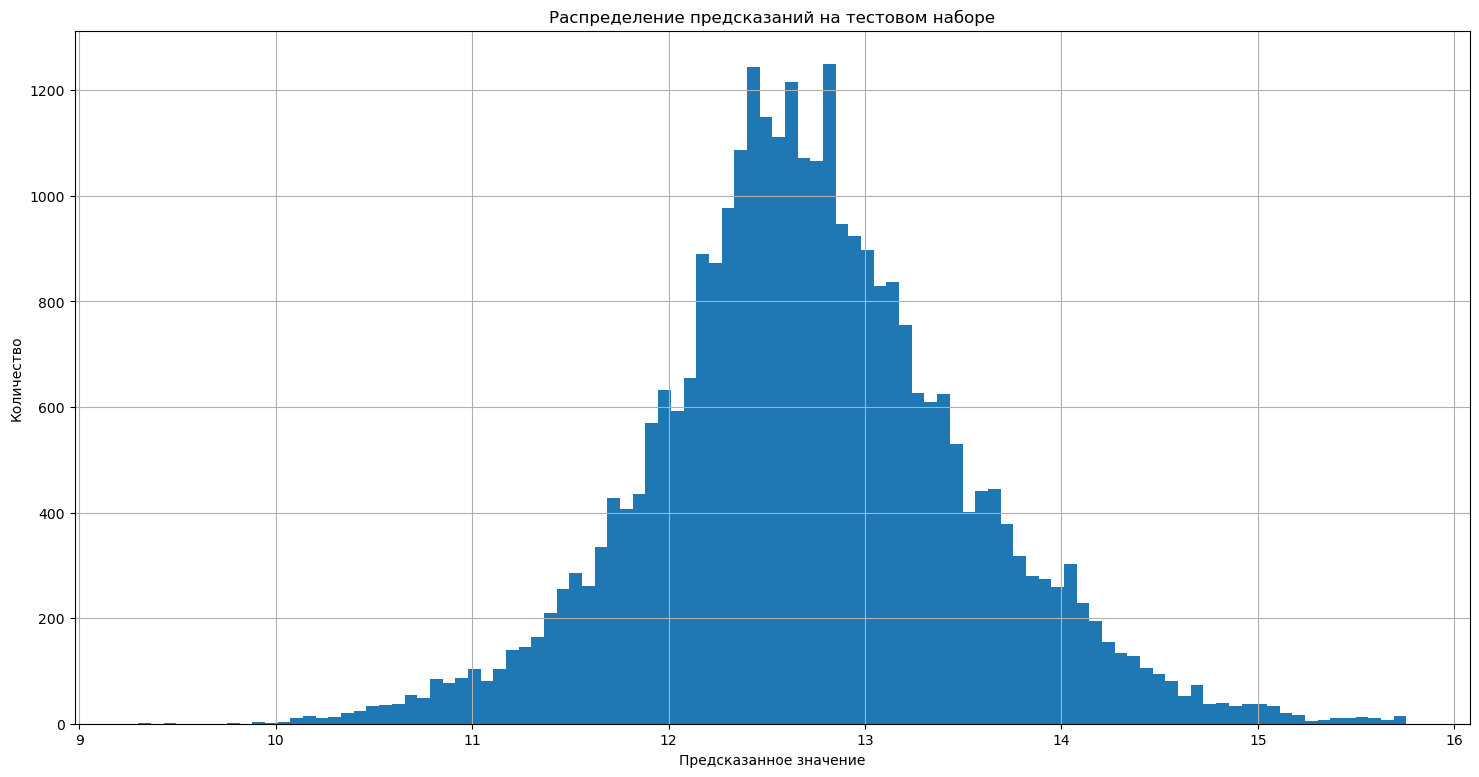

In [5]:
# визуализация результатов на test данных (например, гистограмма предсказаний)
plt.figure(figsize=(18, 9))
plt.hist(test_predict, bins=100)
plt.title("Распределение предсказаний на тестовом наборе")
plt.xlabel("Предсказанное значение")
plt.ylabel("Количество")
plt.grid(True)
plt.show()

In [8]:
# выводим данные по лучшей модели
display(model_h2o_best)

key,value
Stacking strategy,cross_validation
Number of base models (used / total),48/49
# GBM base models (used / total),21/21
# XGBoost base models (used / total),7/7
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),17/18
# GLM base models (used / total),1/1
Metalearner algorithm,GBM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [9]:
# выводим параметры лучшей модели
display(model_h2o_best.params)

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'StackedEnsemble_AllModels_5_AutoML_1_20240403_225912',
   'type': 'Key<Model>',
   'URL': '/3/Models/StackedEnsemble_AllModels_5_AutoML_1_20240403_225912'},
  'input': None},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20240403_225912_training_Key_Frame__upload_81fdf00e454bdc24e38c9f51597b4186.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20240403_225912_training_Key_Frame__upload_81fdf00e454bdc24e38c9f51597b4186.hex'},
  'input': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'AutoML_1_20240403_225912_training_Key_Frame__upload_81fdf00e454bdc24e38c9f51597b4186.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/AutoML_1_20240403_22

In [10]:
# просмотр статистики производительности лучшей модели
performance = model_h2o_best.model_performance()
display(performance)

ModelMetricsRegression: stackedensemble
** Reported on train data. **

MSE: 0.03804469375779142
RMSE: 0.19505049027826465
MAE: 0.1200950451268572
RMSLE: 0.014518639059128669
Mean Residual Deviance: 0.03804469375779142

In [11]:
h2o.save_model(model=model_h2o_best, path="model/h2o", force=True)

'/Users/varlaam/Desktop/Data Science/1. SkillFactory/1. Курс_Profession Data Science/10. Блок 8. Итоговый проект 1 года обучения./model/h2o/StackedEnsemble_AllModels_5_AutoML_1_20240403_225912'

## Подбор гиперпарамсетров модели в H2O

Да, H2O предусматривает возможность подбора гиперпараметров для моделей. H2O использует для этого процесс, называемый Grid Search (поиск по сетке), который позволяет систематически исследовать множество значений гиперпараметров для модели.

Чтобы использовать Grid Search в H2O, вы должны указать, какие гиперпараметры и какие из их значений вы хотите исследовать. После этого H2O обучит модель для каждой комбинации гиперпараметров и вы сможете оценить, какие из них работают лучше всего для вашей задачи.

Вот пример использования Grid Search в H2O для модели градиентного бустинга (GBM):

In [ ]:
# import h2o
# from h2o.grid.grid_search import H2OGridSearch
# from h2o.estimators.gbm import H2OGradientBoostingEstimator

# # Инициализация сессии H2O
# h2o.init()

# # Загрузка данных
# train_data = h2o.H2OFrame(train)

# # Определение столбца, который мы хотим предсказать
# y = 'target_column_name'
# x = train_data.columns
# x.remove(y)

# # Определение гиперпараметров для поиска
# hyper_params = {'learn_rate': [0.01, 0.1],
#                 'max_depth': [3, 5, 9],
#                 'sample_rate': [0.8, 1.0],
#                 'col_sample_rate': [0.2, 0.5, 1.0]}

# # Указание модели
# gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator,
#                          grid_id='gbm_grid1',
#                          hyper_params=hyper_params)

# # Запуск Grid Search
# gbm_grid.train(x=x, y=y, training_frame=train_data, ntrees=50)

# # Вывод лучшей модели
# best_gbm = gbm_grid.get_grid(sort_by='auc', decreasing=True).models[0]
# print(best_gbm)

В примере выше, grid_id используется для идентификации поиска по сетке, hyper_params содержит словарь с гиперпараметрами и их значениями для исследования. Метод train() запускает процесс обучения на сетке гиперпараметров, а get_grid() используется для получения сетки обученных моделей, отсортированных по метрике AUC в убывающем порядке. Метод models[0] возвращает лучшую модель из сетки.

### Комментарии:

В H2O доступно множество моделей, которые можно использовать для решения задач регрессии. Вот список некоторых из них:

* Generalized Linear Model (GLM): Модель обобщенных линейных регрессий, поддерживающая различные распределения и функции связи.
* Gradient Boosting Machine (GBM): Мощный метод ансамбля, который строит модель путем последовательного добавления моделей, уменьшая остаточную ошибку предыдущих моделей.
* Distributed Random Forest (DRF): Ансамблевый метод, использующий множество деревьев решений для улучшения предсказательной способности и контроля за переобучением.
* Deep Learning: Модель на базе искусственных нейронных сетей, которая может использоваться для решения задач регрессии (и классификации), способная обнаруживать сложные нелинейные взаимосвязи в данных.
* Stacked Ensembles: Метод ансамблирования моделей, который объединяет предсказания из различных моделей для получения более точного результата.
* XGBoost: Реализация усиленных деревьев решений, оптимизированная для производительности и скорости.
* AutoML: Автоматический процесс, который проводит поиск по нескольким моделям и их гиперпараметрам для нахождения наилучшей модели для задачи регрессии.
* Cox Proportional Hazards (CoxPH): Модель, используемая для анализа выживаемости, которая может быть применена к регрессионным задачам, связанным с временем до события.

Это не полный список, и H2O продолжает развиваться, добавляя новые модели и функции. Выбор конкретной модели зависит от особенностей вашей задачи, размера и природы набора данных, а также от требований к интерпретируемости и производительности.
